In [1]:
# %% Imports
%env JAX_PLATFORM_NAME=cpu


import jax
from jax import jit, numpy as jnp, lax, random
from functools import partial
from modax.linear_model import SBL

from sklearn.linear_model import ARDRegression

import jax
import jax.numpy as jnp


%load_ext autoreload 
%autoreload 2

env: JAX_PLATFORM_NAME=cpu


In [2]:
def loss_fn_SBL(params, state, model, X, y):
    variables = {"params": params, **state}
    (prediction, dt, theta, coeffs), updated_state = model.apply(
        variables, X, mutable=list(state.keys())
    )
    
    n_samples = theta.shape[0]
    prior_params_mse = (0.0, 0.0)
    
    # MSE stuff
    tau = precision(y, prediction, *prior_params_mse)
    p_mse, MSE = normal_LL(prediction, y, tau)
    
    # Regression stuff
    hyper_prior_params = (n_samples/2, n_samples / (2 * jax.lax.stop_gradient(tau))) # we dont want the gradient
    theta_normed = theta / jnp.linalg.norm(theta, axis=0)
    prior = SBL.SBLregression(theta_normed, dt, hyper_prior_params=hyper_prior_params, max_iter=300, tol=1e-3)
    p_reg, mn = SBL.evidence(theta_normed, dt, prior, hyper_prior_params=hyper_prior_params)
    Reg = jnp.mean((dt - theta_normed @ mn)**2)
    
    
    loss = -(p_mse + p_reg)
    metrics = {"loss": loss, 
               "p_mse": p_mse,
               "mse": MSE, 
               "p_reg": p_reg,
               "reg": Reg, 
               "bayes_coeffs": mn, 
               "coeffs": coeffs, 
               "alpha": prior[:-1], 
               "beta": prior[-1],
               "tau": tau}

    return loss, (updated_state, metrics, (prediction, dt, theta, mn))

In [3]:
from modax.data.burgers import burgers
from modax.data.kdv import doublesoliton
from modax.training import train_max_iter
from modax.models import Deepmod
from modax.training.utils import create_update
from modax.training.losses.utils import precision, normal_LL
from modax.training.losses import loss_fn_pinn

from flax import optim

In [4]:
# %% Making data
key = random.PRNGKey(42)

x = jnp.linspace(-3, 4, 50)
t = jnp.linspace(0.5, 5.0, 20)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
u = burgers(x_grid, t_grid, 0.1, 1.0)

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.10 * jnp.std(y) * random.normal(key, y.shape)

In [5]:
# %% Building model and params
model = Deepmod([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3)
state, params = variables.pop("params")
optimizer = optimizer.create(params)
update_fn = create_update(loss_fn_SBL, (model, X, y))

In [6]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 10000)

Loss step 0: -2912.799072265625
Loss step 1000: -9942.4814453125
Loss step 2000: -10050.4990234375
Loss step 3000: -10056.98046875
Loss step 4000: -10058.203125
Loss step 5000: -10059.353515625
Loss step 6000: -10059.25390625
Loss step 7000: -10066.7138671875
Loss step 8000: -10103.5419921875
Loss step 9000: -10076.091796875


In [20]:
from dataclasses import dataclass

In [21]:
@dataclass
class loss_fn_SBL:
    prior = None
    
    def __call__(self, params, state, model, X, y):
        variables = {"params": params, **state}
        (prediction, dt, theta, coeffs), updated_state = model.apply(
            variables, X, mutable=list(state.keys())
        )

        n_samples = theta.shape[0]
        prior_params_mse = (0.0, 0.0)

        # MSE stuff
        tau = precision(y, prediction, *prior_params_mse)
        p_mse, MSE = normal_LL(prediction, y, tau)

        # Regression stuff
        hyper_prior_params = (n_samples/2, n_samples / (2 * jax.lax.stop_gradient(tau))) # we dont want the gradient
        theta_normed = theta / jnp.linalg.norm(theta, axis=0)
        
        if self.prior is None:
            self.prior = jnp.concatenate((jnp.ones((theta.shape[1],)), 1.0 / jnp.var(dt)[None]), axis=0)
            
        self.prior = SBL.SBLregression(theta_normed, dt, prior_params_init=self.prior, hyper_prior_params=hyper_prior_params, max_iter=300, tol=1e-3)
        p_reg, mn = SBL.evidence(theta_normed, dt, self.prior, hyper_prior_params=hyper_prior_params)
        Reg = jnp.mean((dt - theta_normed @ mn)**2)


        loss = -(p_mse + p_reg)
        metrics = {"loss": loss, 
                   "p_mse": p_mse,
                   "mse": MSE, 
                   "p_reg": p_reg,
                   "reg": Reg, 
                   "bayes_coeffs": mn, 
                   "coeffs": coeffs, 
                   "alpha": self.prior[:-1], 
                   "beta": self.prior[-1],
                   "tau": tau}

        return loss, (updated_state, metrics, (prediction, dt, theta, mn))

In [22]:
# %% Building model and params
model = Deepmod([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3)
state, params = variables.pop("params")
optimizer = optimizer.create(params)
update_fn = create_update(loss_fn_SBL(), (model, X, y))

In [ ]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 10000)

In [88]:
# %% Making data
from modax.data.kdv import doublesoliton
key = random.PRNGKey(42)

x = jnp.linspace(-10, 10, 100)
t = jnp.linspace(0.1, 1.0, 10)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")

u = doublesoliton(x_grid, t_grid, c=[5.0, 2.0], x0=[0.0, -5.0])

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.1 * jnp.std(y) * random.normal(key, y.shape)

In [188]:
# %% Building model and params
model = Deepmod([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3)
state, params = variables.pop("params")
optimizer = optimizer.create(params)
update_fn = create_update(loss_fn_SBL(), (model, X, y))

In [189]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 1743)

Loss step 0: 577.9249877929688
Loss step 1000: -3548.467529296875


In [191]:
variables = {"params": optimizer.target, **state}
(prediction, dt, theta, coeffs), updated_state = model.apply(
    variables, X, mutable=list(state.keys())
)

n_samples = theta.shape[0]
prior_params_mse = (0.0, 0.0)

# MSE stuff
tau = precision(y, prediction, *prior_params_mse)
p_mse, MSE = normal_LL(prediction, y, tau)

In [192]:
print(tau, MSE)

280.1826 0.003569101


In [196]:
import matplotlib.pyplot as plt

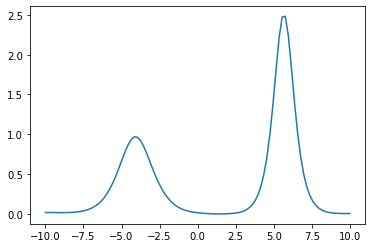

In [197]:
plt.plot(x, prediction.reshape(x_grid.shape)[10, :])

In [198]:
# Regression stuff
hyper_prior_params = (n_samples/2, n_samples / (2 * jax.lax.stop_gradient(tau))) # we dont want the gradient
theta_normed = theta / jnp.linalg.norm(theta, axis=0)

In [199]:
prior = jnp.concatenate((jnp.ones((theta.shape[1],)), 1.0 / jnp.var(dt)[None]), axis=0)
prior = SBL.SBLregression(theta_normed, dt, prior_params_init=prior, hyper_prior_params=hyper_prior_params, max_iter=300, tol=1e-3)

In [200]:
prior[:, None]

DeviceArray([[1.00000000e+04],
             [2.09556885e+03],
             [6.09488792e+01],
             [4.91151841e-05],
             [2.07384300e+00],
             [3.06447801e-05],
             [1.17999390e-02],
             [4.16437724e-05],
             [1.90239563e+01],
             [6.28897920e-04],
             [1.02978395e-02],
             [1.97520872e-04],
             [5.30421143e+02]], dtype=float32)

In [201]:
p_reg, mn = SBL.evidence(theta_normed, dt, prior, hyper_prior_params=hyper_prior_params)
Reg = jnp.mean((dt - theta_normed @ mn)**2)

In [202]:
mn

DeviceArray([[ 7.1788381e-04],
             [ 3.3257250e-04],
             [-5.5806100e-02],
             [-1.4268764e+02],
             [-6.8374097e-01],
             [-1.8063753e+02],
             [ 9.1898775e+00],
             [ 1.5495642e+02],
             [-1.6299558e-01],
             [ 3.9849567e+01],
             [-9.8430386e+00],
             [-7.1147820e+01]], dtype=float32)

In [204]:
from sklearn.linear_model import ARDRegression

reg = ARDRegression(fit_intercept=False, compute_score=True)
reg.fit(theta_normed, dt.squeeze()).lambda_[:, None]

array([[3.08989343e+01],
       [1.18947299e+00],
       [1.74725926e-01],
       [4.85187423e-05],
       [1.76423499e+00],
       [2.93136148e-05],
       [1.74559390e+04],
       [4.01056761e-05],
       [5.90220991e+03],
       [4.92056773e-04],
       [1.23251000e-01],
       [1.97376746e-04]])

In [205]:
p_reg

DeviceArray(5231.853, dtype=float32)

In [207]:
reg.coef_

array([-1.78160273e-01,  8.88121779e-01,  2.39184532e+00, -1.43563759e+02,
       -7.52224131e-01, -1.84697394e+02,  0.00000000e+00,  1.57903578e+02,
       -6.52965854e-04,  4.50674025e+01, -2.84784099e+00, -7.11783106e+01])

In [13]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 10000)

Loss step 0: 2223.37451171875


Loss step 1000: nan


Loss step 2000: nan


KeyboardInterrupt: 